# Determining $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ of DESIJ1101-0602

Author: S M Rafee Adnan, Anowar Shajib

## Load data

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [86]:
data, header = fits.getdata("DESIJ1101-0602_F140W_drz_sci.fits", header=True)

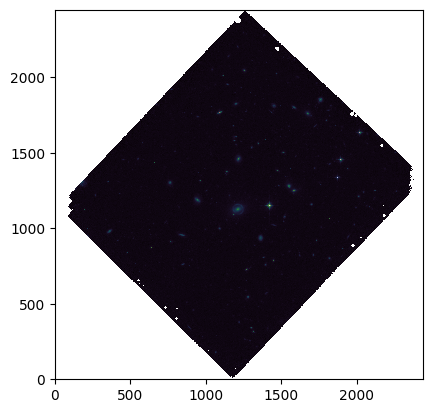

In [87]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [88]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12922/1236197877.py:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


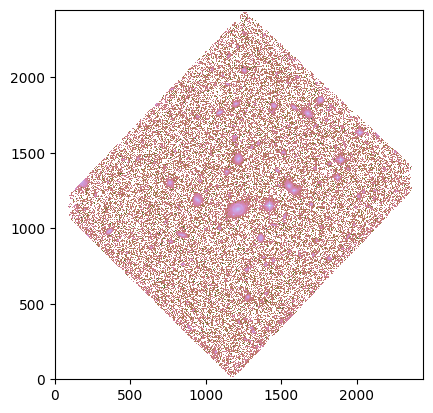

In [89]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [90]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.367671803280672, 0.016745923137648132)

In [91]:
bkg_subtracted_data = data - bkg.background

In [92]:
threshold = 3 * bkg.background_rms

In [93]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [94]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [95]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2448, 2439)
nlabels: 796
labels: [  1   2   3   4   5 ... 792 793 794 795 796]


In [104]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 796
labels: [  1   2   3   4   5 ... 792 793 794 795 796]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [117]:
set_x_lim1, set_x_lim2 = 850, 1550
set_y_lim1, set_y_lim2 = 800, 1400

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12922/66409615.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


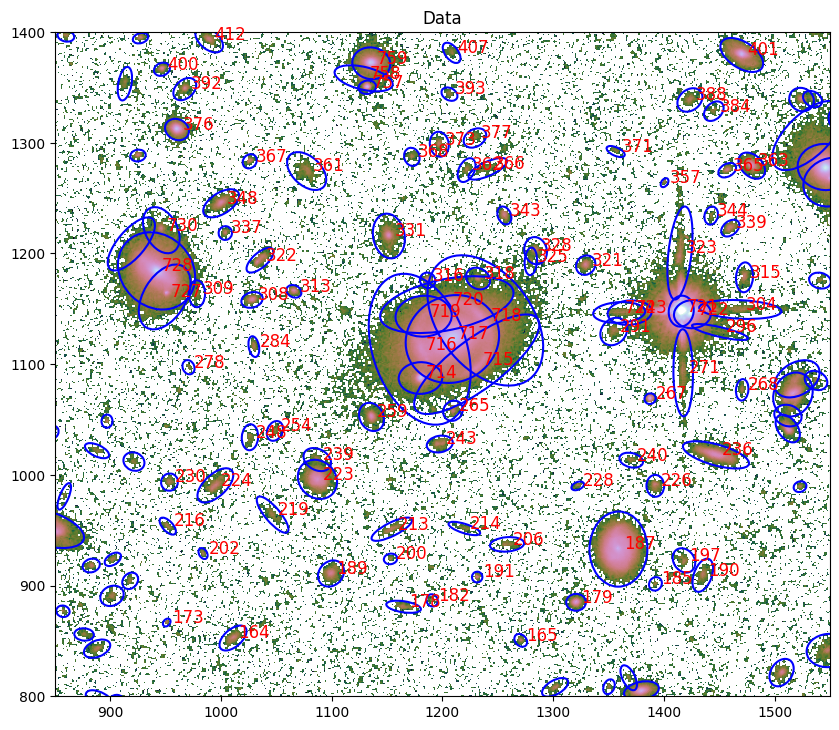

In [118]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

# # Before determining the central ID
# for i in range(len(cat)):
#     ax1.text(
#         cat.xcentroid[i] + 5,
#         cat.ycentroid[i],
#         f"{i}",
#         c="r",
#         fontsize=12
#     )

# After determining the central ID
id_central = 717
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[id_central]) < 280
        and np.abs(cat.ycentroid[i] - cat.ycentroid[id_central]) < 280
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12922/3133394023.py:7: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


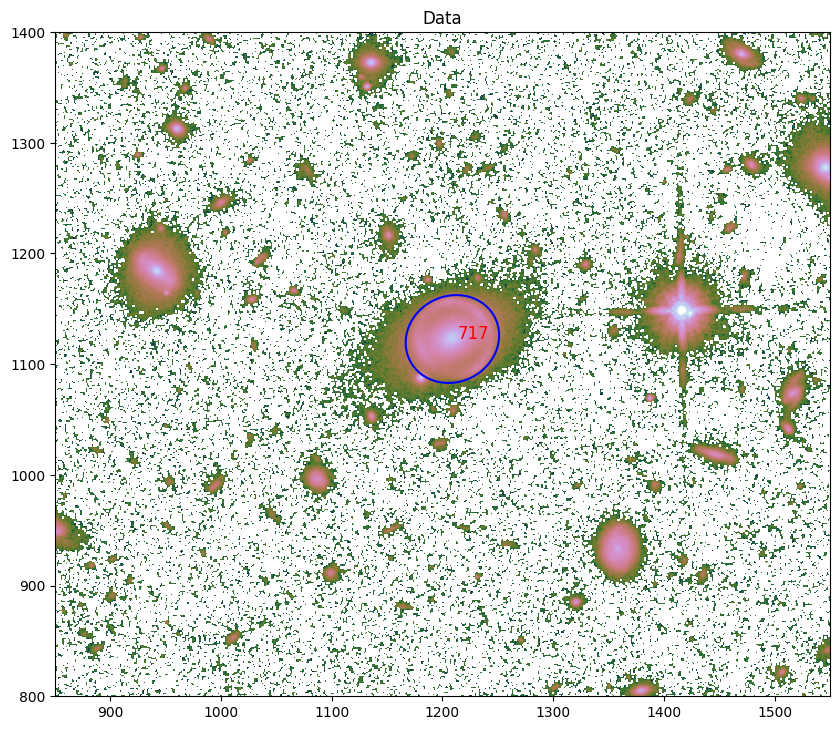

In [119]:
# object id of your central deflector/lens
id_central = 717
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12,
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [120]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [121]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (
        np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08
    ):  # Find neighbouring galaxies within 20 arcseconds
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 30 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 30 arcsecond radius: 124


In [122]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 30 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 30 arcsecond radius: 36


In [123]:
def distance_arcsec(pixel_distance):
    """Convert distance from unit of pixels into arcsec unit.

    :param pixel_distance: distance in unit of pixels

    :return: distance in arcsec unit

    """
    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

In [124]:
# list of galaxies you want removed
remove_list = [
    717,  # This is the central deflector
    715,  # Object is part of the lensed arc
    716,  # Object is part of the lensed arc
    718,  # Object is part of the lensed arc
    719,  # Object is part of the lensed arc
    720,  # Object is part of the lensed arc
    721,  # Object is a star
    722,  # Object is part of diffraction spikes of a star
    723,  # Object is part of diffraction spikes of a star
    724,  # Object is part of diffraction spikes of a star
    323,  # Object is part of diffraction spikes of a star
    713,  # Spiral arm of Object ID 712
]

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(arcsec)        Flux  Axis Ratio
714         45.513981          3.641119  169.907566    0.726546
316         57.561918          4.604953    8.494737    0.944406
318         59.348030          4.747842   10.893937    0.800776
265         64.760982          5.180879    8.137725    0.887518
243         95.540718          7.643257   10.134560    0.626040
325         99.669845          7.973588    4.131273    0.444937
259        101.428311          8.114265   28.820442    0.801178
331        109.316901          8.745352   41.615928    0.697179
328        109.598037          8.767843    9.867073    0.817109
343        121.071277          9.685702   10.120527    0.704403
321        137.655288         11.012423   12.816484    0.894487
291        145.930392         11.674431    7.738609    0.817422
313        149.450245         11.956020   10.060562    0.764408
362        153.102120         12.248170    4.159102    0.605628
366        157.022727         12.561818 

In [125]:
remove_list_1 = [
    717,  # This is the central deflector
    715,  # Object is part of the lensed arc
    716,  # Object is part of the lensed arc
    718,  # Object is part of the lensed arc
    719,  # Object is part of the lensed arc
    720,  # Object is part of the lensed arc
    721,  # Object is part of diffraction spikes of a star
    722,  # Object is part of diffraction spikes of a star
    323,  # Object is part of diffraction spikes of a star
    713,  # Spiral arm of Object ID 712
]
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(arcsec)         Flux  Axis Ratio
714         45.513981          3.641119   169.907566    0.726546
259        101.428311          8.114265    28.820442    0.801178
331        109.316901          8.745352    41.615928    0.697179
223        175.851941         14.068155   116.757217    0.866102
267        186.502405         14.920192    23.726797    0.924068
189        238.477780         19.078222    21.973481    0.828810
757        240.073487         19.205879    36.510039    0.748750
187        241.854287         19.348343   702.576124    0.770253
348        242.188303         19.375064    29.816091    0.518362
224        251.625038         20.130003    20.417835    0.497892
759        259.614394         20.769152   203.586773    0.830409
236        260.075025         20.806002   101.152035    0.304868
727        262.610666         21.008853    75.252282    0.597115
179        262.742092         21.019367    30.018545    0.857481
728        274.220466    

## Visualizing removed objects (except central deflector)

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12922/303734189.py:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


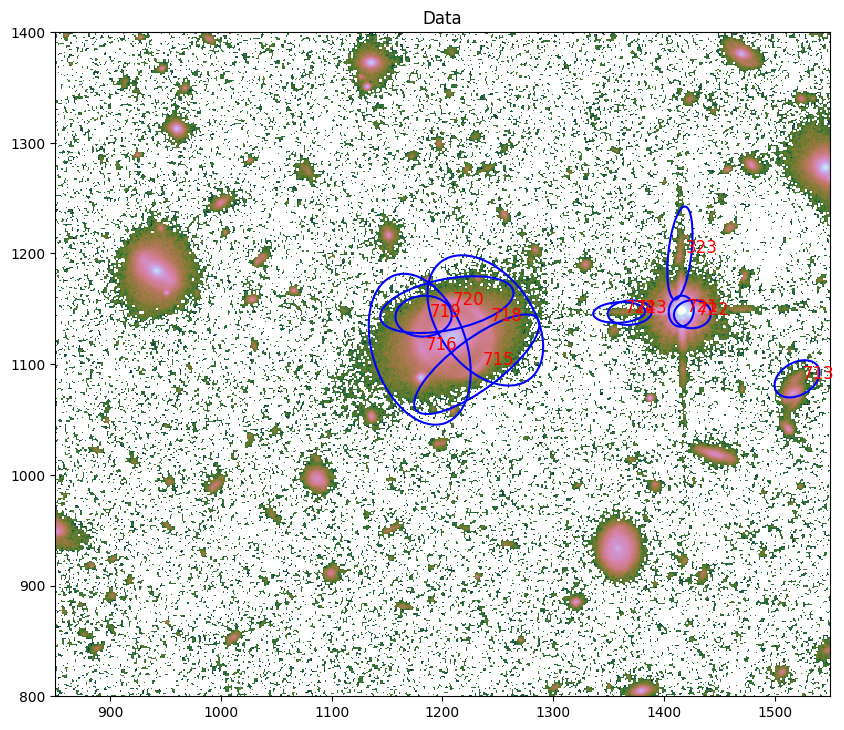

In [126]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

remove_list_exc_central = remove_list
if id_central in remove_list_exc_central:
    remove_list_exc_central.remove(id_central)

updated_remove_list = [s + 1 for s in remove_list_exc_central]
cat_subset_removed = cat.get_labels(updated_remove_list)
cat_subset_removed.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in remove_list:
    ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determining Sigma 10, 20 and R 10, 20

/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12922/143537777.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12922/143537777.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12922/143537777.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/var/folders/9n/3ndvcp611qzclyd98l4cx0mm0000gn/T/ipykernel_12922/143537777.py:29: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


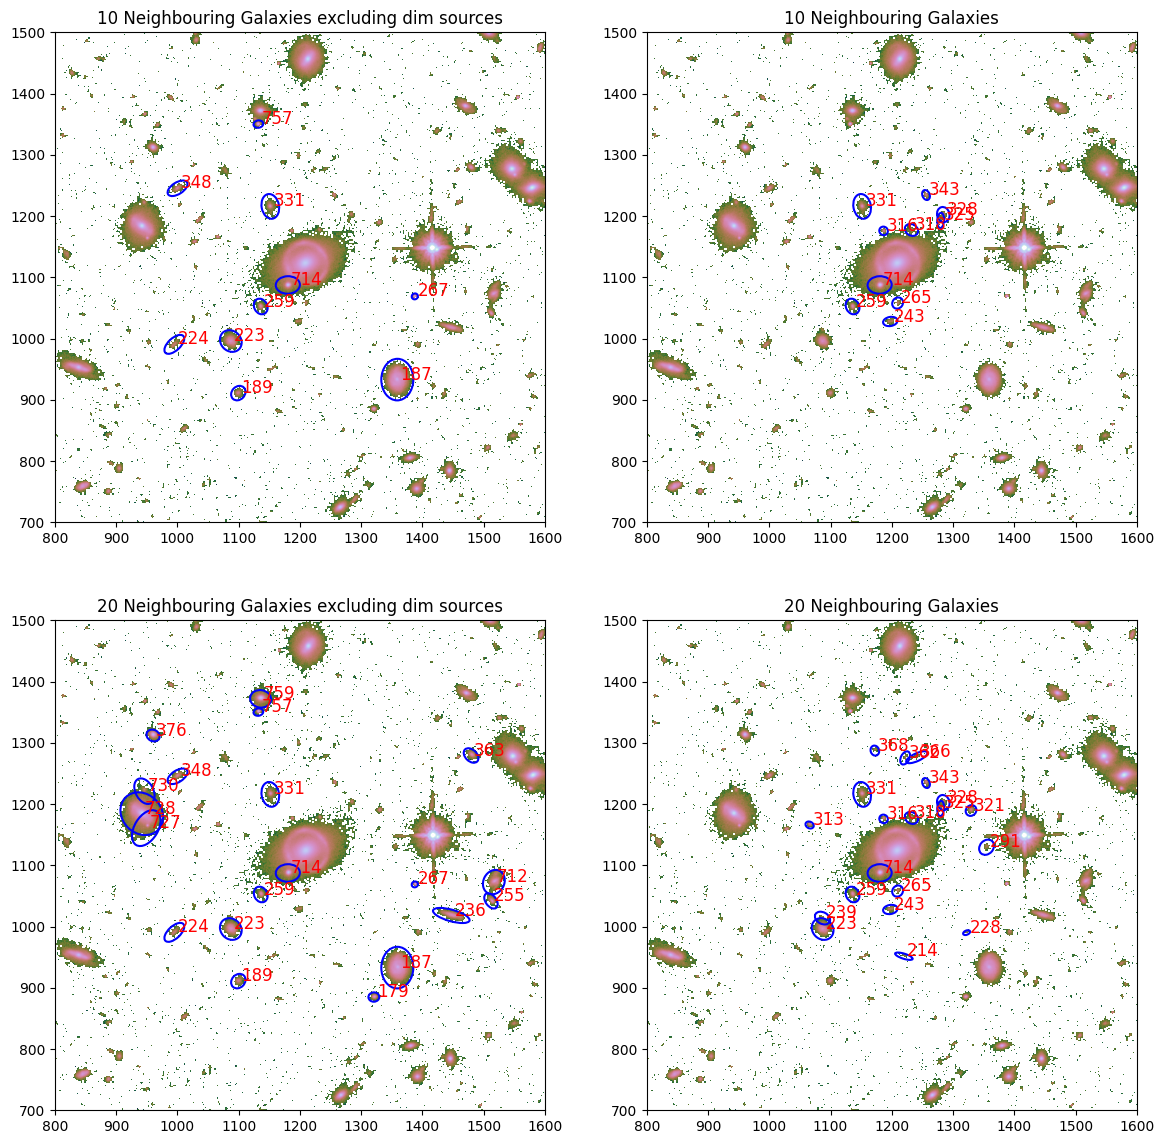

In [127]:
set_x_lim1_, set_x_lim2_ = 800, 1600
set_y_lim1_, set_y_lim2_ = 700, 1500

close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("10 Neighbouring Galaxies")
axs[1, 0].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1_, set_x_lim2_)
axs[0, 0].set_ylim(set_y_lim1_, set_y_lim2_)

axs[0, 1].set_xlim(set_x_lim1_, set_x_lim2_)
axs[0, 1].set_ylim(set_y_lim1_, set_y_lim2_)

axs[1, 0].set_xlim(set_x_lim1_, set_x_lim2_)
axs[1, 0].set_ylim(set_y_lim1_, set_y_lim2_)

axs[1, 1].set_xlim(set_x_lim1_, set_x_lim2_)
axs[1, 1].set_ylim(set_y_lim1_, set_y_lim2_)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

In [128]:
R_10_1 = df_1_20.iloc[
    9, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_1 = df_1_20.iloc[
    19, df_1_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[
    9, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
R_20_all = df_all_20.iloc[
    19, df_all_20.columns.get_loc("Distance(arcsec)")
]  # exclude satellite galaxy
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)


EXCLUDING DIM SOURCES
R 10: 20.13000303808231
R 20: 25.08023914353471
Sigma 10: 0.007855294043836105
Sigma 20: 0.010120845064708896

FOR All SOURCES
R 10: 9.685702167690481
R 20: 14.068155241730935
Sigma 10: 0.03393031615432308
Sigma 20: 0.03216664890154074


## Save the final deriverables to the YAML file

In [129]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1101-0602_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20_flux_selected": Sigma_20_1,
    "Sigma_10": Sigma_10_all,
    "Sigma_20": Sigma_20_all,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [130]:
with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 1.3280313878820786, 'Sigma_10': 0.03393031615432308, 'Sigma_10_flux_selected': 0.007855294043836105, 'Sigma_20': 0.03216664890154074, 'Sigma_20_flux_selected': 0.010120845064708896, 'center_x_light': [-0.4800830469153752, 0.001477657866552129, 0.0017080750313543946], 'center_x_mass': [-0.4894282136895256, 0.003710506253172763, 0.0031703901066623685], 'center_y_light': [0.1971557292544064, 0.0014518486585159973, 0.0014430927066691746], 'center_y_mass': [0.22880604723266185, 0.0024268116094950942, 0.0024594206593055445], 'gamma': 2.0, 'gamma_shear': [0.038230328689120574, 0.0025913420606199083, 0.0027401096708327202], 'phi_light': [-0.4111419313019572, 0.002635047102442334, 0.0026596107345483455], 'phi_mass': [-0.3915745546668806, 0.008050356215271504, 0.01141948020458089], 'phi_shear': [-0.09883256100462795, 0.02395998854910046, 0.02667270153473897], 'q_light': [0.6306360350479552, 0.0013957807922510002, 0.0016421680930061022], 'q_mass': [